In [1]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [27,41,-13,2]
rxn,rxx,ryn,ryx = [34.5,38,-2,1]
mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file("sf")

In [2]:
sf_lv = gpd.read_file("sf_lvictoria")
sf_lt = gpd.read_file("sf_ltanganyika")
# sf_tc = gpd.read_file("sf_tanzaniaCoast")
# sf_ch = gpd.read_file("sf_centralHighlands")
sf_box = gpd.GeoDataFrame(pd.DataFrame(data = {"region" : ["box"]}, index = [0]), geometry = [Polygon(zip([rxn,rxn,rxx,rxx,rxn], [ryn,ryx,ryx,ryn,ryn]))], crs = "EPSG:4326")

# sf_vt = gpd.read_file("sf_lvictoriaTanganyika")
sf_org = gpd.read_file("sf")

sf_names = {"lv" : "Lake Victoria basin", "lt" : "Lake Tanganyika basin", "tc" : "southeast Tanzania",
            "ch" : "Central Highlands to coast", "box" : "Central Highlands", "vt" : "Lake Victoria & Tanganyika basins", "org" : "Tanzania/Burundi/SW Kenya"}

# Climate models

## HighResMIP

### Extract data over the region

In [4]:
ml = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_Mariam/data/highresmip/*/pr/"))
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/"

In [7]:
for fnm in glob.glob(outpath+"*"):
    print(fnm, xr.open_dataset(fnm).time.max().values)

/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_CMCC-CM2-HR4_r1i1p1f1_gn.nc 2050-12-31 12:00:00
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_FGOALS-f3-L_r1i1p1f1_gr.nc 2024-12-31 12:00:00
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_FGOALS-f3-H_r1i1p1f1_gr.nc 2024-12-31 12:00:00
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_NICAM16-8S_r1i1p1f1_gr.nc 2024-12-31T12:00:00.000000000
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_NICAM16-7S_r1i1p1f1_gr.nc 2024-12-31T12:00:00.000000000
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_HadGEM3-GC31-LM_r1i1p1f1_gn.nc 2024-12-30 12:00:00
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/pr_day_EC-Earth3

In [57]:
for mpath in ml:
    
    print(mpath.split("/")[-3])
    fl_hist = sorted(glob.glob(mpath+"*present*[0-9].nc"))
    fl_fut = sorted(glob.glob(mpath+"*future*[0-9].nc"))

    # filter file list to remove duplicated years
    last_hist = fl_hist[-1][-11:-3]
    fl_fut = [fnm for fnm in fl_fut if fnm[-20:-12] > last_hist]

    new_fnm = outpath + "pr_day_"+"_".join(fl_hist[0].split("_")[6:7]+fl_hist[0].split("_")[-3:-1])+".nc"
    
    if os.path.exists(new_fnm): continue
    da = xr.open_mfdataset(fl_hist + fl_fut).pr.sel(lon = slice(xn-2,xx+2), lat = slice(yn-2,yx+2))

    da.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

In [ ]:
# time series, spatial & seasonal patterns
for fnm in glob.glob(outpath+"*.nc"):
    
    mdl = "_".join(fnm.split("_")[-3:-1])
    da = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    
    if len(da.sel(time = slice("1990","2020")).time) == 0: continue
    
    # spatial pattern
    sp = da.resample(time = "QS-DEC").sum().groupby("time.season")["MAM"].sel(time = slice("1990", "2020")).mean("time")
    sp.to_netcdf("data/highresMIP/"+re.sub("day", "spatial", fnm.split("/")[-1]))
    
    # daily time series
    for sf_nm in list(sf_names.keys()):
        sf = eval("sf_"+sf_nm)
        rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
        ts = da.where(rm == 0).mean(["lat", "lon"])
    
        # seasonal cycle
        sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
        sc.to_netcdf("data/highresMIP/"+re.sub("_day", "-"+sf_nm+"_seasonal-cycle", fnm.split("/")[-1]))
    
        # create time series for Climate Explorer
        for ndays in [30]:

            rxnday = ts.rolling(time = ndays).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
            rxnday = rxnday.assign_coords(time = rxnday.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "EA-floods_rx"+str(ndays)+"day-"+sf_nm+"_highresmip_"+mdl
            csv_fullpath = "ts_highresmip/"+csv_fnm+".dat"
            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: HighResMIP "+mdl+" MAM maxima of rx"+str(ndays)+"day - East Africa floods 2024, c.barnes22@imperial.ac.uk"
            str2 = "# rx"+str(ndays)+"day [mm] March-May maximum of "+str(ndays)+"-day accumulated precipitation over "+sf_names[sf_nm]+" at "+csv_fnm+".dat"
            head = "# year rx"+str(ndays)+"day"

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            rxnday.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

## CORDEX

In [29]:
abridge_gcm = {'CCCma-CanESM2' : "CanESM2",
               "CNRM-CERFACS-CNRM-CM5" : "CNRM-CM5",
               'CSIRO-QCCCE-CSIRO-Mk3-6-0' : 'CSIRO-Mk3-6-0',
               "ICHEC-EC-EARTH" : "EC-EARTH",
               'IPSL-IPSL-CM5A-LR' : 'IPSL-CM5A-LR',
               'IPSL-IPSL-CM5A-MR' : 'IPSL-CM5A-MR',
               'MIROC-MIROC5' : 'MIROC5',
               'MOHC-HadGEM2-ES' : 'HadGEM2-ES',
               'MPI-M-MPI-ESM-LR' : 'MPI-ESM-LR',
               'MPI-M-MPI-ESM-MR' : 'MPI-ESM-MR',
               'NCC-NorESM1-M' : 'NorESM1-M',
               'NOAA-GFDL-GFDL-ESM2G' : 'GFDL-ESM2G',
               'NOAA-GFDL-GFDL-ESM2M' : 'GFDL-ESM2M'}

abridge_rcm = {'CCCma-CanRCM4' : "CanRCM4",
               'CLMcom-CCLM4-8-17': "CCLM4-8-17",
                 'CLMcom-ETH-COSMO-crCLIM-v1-1': "COSMO-crCLIM-v1-1",
                 'CNRM-ALADIN63':"ALADIN63",
                 'DMI-HIRHAM5':"HIRHAM5",
                 'GERICS-REMO2015':"REMO2015",
                 'ICTP-RegCM4-3':"RegCM4-3",
                 'ICTP-RegCM4-6':"RegCM4-6",
                 'ICTP-RegCM4-7':"RegCM4-7",
                 'IPSL-WRF381P':"WRF381P",
                 'KNMI-RACMO22E':"RACMO22E",
               'KNMI-RACMO22T':"RACMO22T",
                 'MOHC-HadREM3-GA7-05':"HadREM3-GA7-05",
                 'MPI-CSC-REMO2009':"REMO2009",
                 'SMHI-RCA4':"RCA4",
                 'UCAN-WRF341I':"WRF341I",
                 'UHOH-WRF361H':"WRF361H"}

In [34]:
ml = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/CORDEX/*.nc"))
for fnm in ml:
    
    mdl = abridge_gcm[fnm.split("_")[8]]+"_"+abridge_rcm[fnm.split("_")[11]]
    ts = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")

    for ndays in [30]:

        rxnday = ts.rolling(time = ndays).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
        rxnday = rxnday.assign_coords(time = rxnday.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "EA-floods_rx"+str(ndays)+"day-org_cordex_"+mdl
        csv_fullpath = "ts_cordex/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+mdl+" MAM maxima of rx"+str(ndays)+"day - East Africa floods 2024, c.barnes22@imperial.ac.uk"
        str2 = "# rx"+str(ndays)+"day [mm] March-May maximum of "+str(ndays)+"-day accumulated precipitation over Tanzania/Burundi/SW Kenya at "+csv_fnm+".dat"
        head = "# year rx"+str(ndays)+"day"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        rxnday.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

        clear_output(wait = False)

## CMIP6

### Daily time series

In [34]:
for fnm in sorted(glob.glob("data/cmip6/*_mon_*.nc")):
    
    print(fnm)
    da = decode_times(xr.open_dataset(fnm, decode_times = False))
    
    if "longitude" in da.dims: da = da.rename(longitude = "lon", latitude = "lat")
    
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    ts = da.pr.where(rm == 0).mean(["lat", "lon"])
    
    mdl = da.source_id+"_"+da.variant_label
    new_fnm = "data/cmip6/pr-org_day_"+mdl+".nc"
    
    ts.to_netcdf(new_fnm)
    
clear_output(wait = False)

### Spatial pattern

In [39]:
for fnm in sorted(glob.glob("data/cmip6/*_mon_*.nc")):
    
    print(fnm)
    da = decode_times(xr.open_dataset(fnm, decode_times = False))
        
    sp = da.resample(time = "QS-DEC").sum().groupby("time.season")["MAM"].sel(time = slice("1990","2020")).mean("time")
    
    mdl = da.source_id+"_"+da.variant_label
    new_fnm = "data/cmip6/pr_spatial_"+mdl+".nc"
    
    sp.to_netcdf(new_fnm)
    
clear_output(wait = False)

### Seasonal cycle

In [35]:
for fnm in sorted(glob.glob("data/cmip6/*_EAF_*.nc")):
    
    print(fnm)
    
    mdl = fnm.split("_")[4]+"_"+fnm.split("_")[6]
    ts = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    
    sc.to_netcdf("data/cmip6/pr-org_seasonal-cycle_"+mdl+".nc")
    
clear_output(wait = False)

### Time series for climate explorer 

In [30]:
ndays = 30
ml = sorted(glob.glob("data/cmip6/*EAF*.nc"))
for fnm in ml:
    
    mdl = fnm.split("_")[4]+"_"+fnm.split("_")[6]
    ts = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    ts = ts.rolling(time = 30).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()
    
    csv_fnm = "EA-floods_rx30day-org_cmip6_"+mdl
    csv_fullpath = "ts_cmip6/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" MAM maxima of rx"+str(ndays)+"day - East Africa floods 2024, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] March-May maximum of "+str(ndays)+"-day accumulated precipitation over Tanzania/Burundi/SW Kenya at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

# Gridded observational products

In [4]:
# ds = "chirps"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_chirps_1981-2024_EA.nc")).precip.rename("pr", longitude = "lon", latitude = "lat")
# ds = "tamsat"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_tamsat_1983-2024_EA.nc")).rfe.rename("pr")
# ds = "mswep"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/MSWEP/mswep_EA_*.nc")).precipitation.rename("pr")
# ds = "cpc"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cpc/precip*.nc")).precip.rename("pr")

In [42]:
ds = "era5"; da = wrap_lon(xr.open_dataset("data/era5_tp_daily_af_27-41E_-12-2N_su.nc")).tp.rename("pr")

In [43]:
# Daily time series from shapefiles
for sf_nm in list(sf_names.keys()):
    sf = eval("sf_"+sf_nm)
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    ts = da.where(rm == 0).mean(["lat", "lon"])
    ts.to_netcdf("data/daily-ts_"+sf_nm+"_"+ds+".nc")

In [6]:
# gridded n-day seasonal maxima
for ndays in [30]:
    da = da.sel(lon = slice(xn,xx), lat = slice(yn,yx))
    rxnday = da.rolling(time = ndays, center = False).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
    rxnday.to_netcdf("data/rx"+str(ndays)+"day-MAM_gridded_"+ds+".nc")

In [ ]:
# 2024 event
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/"

for ds in ["chirps", "cpc", "era5", "mswep", "tamsat"]:
    if ds == "chirps": 
        da = wrap_lon(xr.open_dataset(fpath+"precip_chirps_1981-2024_EA.nc")).precip.rename("pr", longitude = "lon", latitude = "lat").sel(time = "2024")
    elif ds == "cpc" : 
        da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cpc/precip*.nc")).precip.rename("pr")
    elif ds == "era5" : 
        da = wrap_lon(xr.open_dataset("data/era5_tp_daily_af_27-41E_-12-2N_su.nc")).tp.rename("pr")
    elif ds == "mswep" : 
        da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/MSWEP/mswep_EA_*.nc")).precipitation.rename("pr")
    elif ds == "tamsat" : 
        da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_tamsat_1983-2024_EA.nc")).rfe.rename("pr")
        
    whichmax = xr.open_dataset("data/daily-ts_org_"+ds+".nc").pr.sel(time = "2024").rolling(time = 30, center = False).sum().sel(time = slice("2024-03",None)).idxmax()
    event = da.rolling(time = 30, center = False).sum().sel(time = whichmax).sel(lon = slice(xn, xx), lat = slice(yn,yx))
    event.to_netcdf("data/event-map_"+ds+".nc")

## Time series for climate explorer

In [8]:
datasets = ["chirps", "cpc", "era5", "mswep", "tamsat"]
for ndays in [3]:
    for region in ["box"]: #list(sf_names.keys()):
        for ds in datasets:

            ts = xr.open_dataset("data/daily-ts_"+region+"_"+ds+".nc").pr
            ts = ts.rolling(time = ndays, center = False).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
            ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

            csv_fnm = "EA-floods_rx"+str(ndays)+"day_obs-"+region+"_"+ds
            csv_fullpath = "ts_obs/"+csv_fnm+".dat"

            if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
                
            rnm = sf_names[region]

            # create extra header lines for upload to Climate Explorer 
            str1 = "# contact :: "+ds.upper()+" MAM maxima of rx"+str(ndays)+"day averaged over "+rnm+" - East Africa floods 2024, c.barnes22@imperial.ac.uk"
            str2 = "# rx"+str(ndays)+"day [mm] March-May maxima of "+str(ndays)+"-day accumulated precipitation at "+csv_fnm+".dat"
            head = "# year rx"+str(ndays)+"day"

            # make .dat file
            ! echo "$str1 " > $csv_fullpath
            ! echo "$str2" >> $csv_fullpath
            ! echo "$head" >> $csv_fullpath
            ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

            clear_output(wait = False)

# MAM climatology 1990-2020

In [10]:
# ds = "chirps"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_chirps_1981-2024_EA.nc")).precip.rename("pr", longitude = "lon", latitude = "lat")
# ds = "tamsat"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_tamsat_1983-2024_EA.nc")).rfe.rename("pr")
# ds = "mswep"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/MSWEP/mswep_EA_*.nc")).precipitation.rename("pr")
ds = "cpc"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cpc/precip*.nc")).precip.rename("pr")

In [ ]:
clim = da.resample(time = "QS-DEC").sum().groupby("time.season")["MAM"].sel(time = slice("1990", "2020")).mean("time")
clim = clim.where(clim > 0)
clim.to_netcdf("data/mam-climatology_"+ds+".nc")

## Flatten gridded data for trend fitting

In [8]:
# gridded n-day seasonal maxima over study region only
ndays = 30
for ds in ["chirps", "cpc", "mswep", "tamsat"][:1]:
    
    da = xr.open_dataset("data/rx"+str(ndays)+"day-MAM_gridded_"+ds+".nc").pr
    da = da.assign_coords(time = da.time.dt.year).rename(time = "year")
    
    if ds in ["mswep"]:
        # mask out the sea
        rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
        da = da.where(rm == 0)

    # save the map for easier reconstruction later
    da.mean("year").to_netcdf("data/map-tmplt_"+ds+".nc")
    
    # flatten & save as .csv for transfer to R
    da_df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()
    
    if da_df.shape[1] > 2500:
        for i in range(int(np.ceil(da_df.shape[1] / 2500))):
            da_df.iloc[:,slice(i*2500,(i+1)*2500)].to_csv("data/flattened/rx"+str(ndays)+"days-flattened_"+ds+"_"+str(i+1).rjust(2,"0")+".csv")
    else:
        da_df.to_csv("data/flattened/rx"+str(ndays)+"days-flattened_"+ds+".csv")
    

## Reshape dataframe into maps

In [36]:
warnings.filterwarnings("ignore", category = FutureWarning) # otherwise there will be a LOT of warnings

def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [38]:
ndays = 30
datasets = ["tamsat", "chirps", "cpc", "mswep"]
for ds in datasets:
    
    new_fnm = "res/res-gridded_rx"+str(ndays)+"day_"+ds+".nc"
    if os.path.exists(new_fnm): continue
    
    # load map to be used to reshape
    tmplt = xr.open_dataset("data/map-tmplt_"+ds+".nc").pr
    
    df = merge_byindex([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("data/gridded-res/rx"+str(ndays)+"day*_"+ds+"*.csv"))])
    mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    mdl_res.to_netcdf(new_fnm)

# Covariates

## MAM IOD

In [45]:
iod = decode_times(xr.open_dataset("data/idmi_ersst.nc", decode_times = False))["diff"].rename("IOD")

iod_mam = iod.resample(time = "QS-DEC").mean().groupby("time.season")["MAM"]
iod_mam = iod_mam.assign_coords(time = iod_mam.time.dt.year).rename(time = "year").to_dataframe()
ts = iod_mam

In [29]:
csv_fnm = "EA-floods_iod-mam_obs_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: MAM IOD (ERSST) - East Africa floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# iod [degC] March-May mean of IOD at "+csv_fnm+".dat"
head = "# year iod"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
iod_mam.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

## DJF detrended Nino3.4

In [48]:
nino = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34
nino_djf = nino.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"]
nino_djf = nino_djf.assign_coords(time = nino_djf.time.dt.year + 1).rename(time = "year").to_dataframe()
ts = nino_djf

csv_fnm = "EA-floods_nino-djf_obs_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: DJF detrended Nino3.4 (ERSST) - East Africa floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# nino [degC] December-February mean of Nino3.4 detrended by subtracting mean of tropical SSTs at "+csv_fnm+".dat"
head = "# year nino"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

## Mean 850hPa geopotential height during May

In [34]:
z = decode_times(xr.open_dataset("data/iera5_z850_50-75E_10-25N_n_su_5_.nc", decode_times = False)).z
z = z.assign_coords(time = z.time.dt.year).rename(time = "year")
z.to_pandas().to_csv("data/850hPa-geopotential-height.csv")

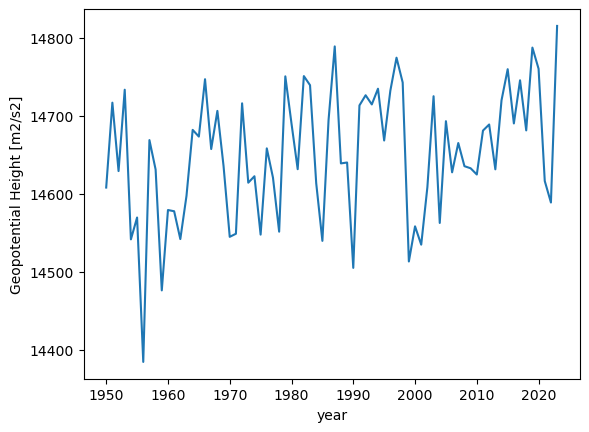

In [33]:
z.plot()

## Mean SST gradient over Arabian Sea during May

In [12]:
sst_n = decode_times(xr.open_dataset("data/iersstv5_60-70E_18-24N_n_su.nc", decode_times = False)).sst
sst_s = decode_times(xr.open_dataset("data/iersstv5_50-78E_6-12N_n_su.nc", decode_times = False)).sst

In [39]:
sst_gradient = (sst_s - sst_n).groupby("time.month")[5].resample(time = "AS-MAY").mean()
sst_gradient = sst_gradient.assign_coords(time = sst_gradient.time.dt.year).rename(time = "year")
sst_gradient.to_pandas().to_csv("data/sst-gradient.csv")

sst_gradient.rolling(year = 4, center = True, min_periods = 2).mean().to_pandas().to_csv("data/sst-gradient-sm4y.csv")

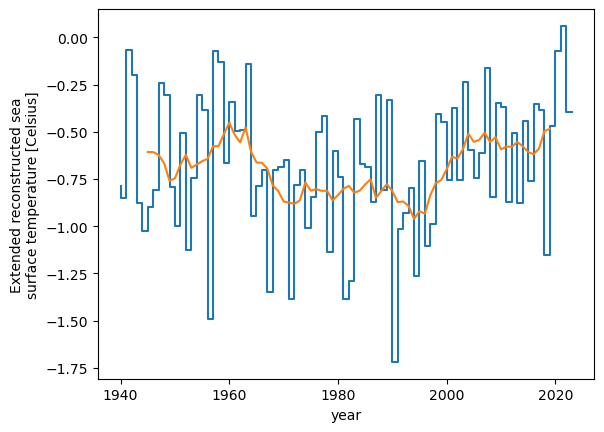

In [29]:
sst_gradient = sst_gradient.sel(year = slice(1940, 2024))

sst_gradient.plot(drawstyle = "steps")
sst_gradient.rolling(year = 10, center = True).mean().plot()